In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import collections
from tqdm import tqdm
import json
import numpy as np
import os
import lazyqsar as lq
import pandas as pd

data_dir = "../data/"
model_dir = "../models/"
figure_dir = "../figures/"
N_FOLDS = 5

def cross_validate(smiles_list, y, name, descriptor, method):

    cross_validation_data = collections.defaultdict(list)

    for _ in tqdm(range(N_FOLDS)):
        smiles_train, smiles_test, y_train, y_test = train_test_split(
            smiles_list,y, test_size=0.2, stratify=y
        )

        model = lq.LazyBinaryQSAR(model_type=method, descriptor_type=descriptor)
        model.fit(smiles_train, y_train)
        y_pred = model.predict_proba(smiles_test)

        fpr, tpr, thr = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        J = tpr - fpr

        best_thr_index = np.argmax(J)
        best_thr = thr[best_thr_index]

        cross_validation_data["roc_auc"] += [roc_auc]
        cross_validation_data["thr"] += [best_thr]
        cross_validation_data["y_hat"] += [list(y_pred)]
        cross_validation_data["y"] += [list(y_test)]

    with open(
        os.path.join(model_dir, f"{name}.json"),
        "w",
    ) as f:
        json.dump(cross_validation_data, f, indent=4)

# Internal Data only

In [2]:
df = pd.read_csv(os.path.join(data_dir, "processed", "all_molecules.csv"))
print(len(df[df["activity"] == 1]), "active molecules")
print(len(df[df["activity"] == 0]), "inactive molecules")

754 active molecules
81 inactive molecules


In [ ]:
%%capture
cross_validate(df["canonical_smiles"], df["activity"].tolist(), "internal_all_morgan", "morgan", "zsrandomforest")
cross_validate(df["canonical_smiles"], df["activity"].tolist(), "internal_all_mordred", "mordred", "zsrandomforest")

## NP only

In [3]:
%%capture
df_np = df[df["category"]=="natural"]
#cross_validate(df_np["canonical_smiles"], df_np["activity"].tolist(), "internal_np_morgan", "morgan", "zsrandomforest")
cross_validate(df_np["canonical_smiles"], df_np["activity"].tolist(), "internal_np_mordred", "mordred", "zsrandomforest")

## SD only

In [4]:
%%capture
df_sd = df[df["category"]=="synthetic"]
#cross_validate(df_sd["canonical_smiles"], df_sd["activity"].tolist(), "internal_sd_morgan", "morgan", "zsrandomforest")
cross_validate(df_sd["canonical_smiles"], df_sd["activity"].tolist(), "internal_sd_mordred", "mordred", "zsrandomforest")

# External negative data
50-50 chembl coconut

In [5]:
pos = df[df["activity"]==1]
neg_sd = pd.read_csv(os.path.join(data_dir, "chembl", "chembl_smi.csv"))
neg_sd = neg_sd.sample(frac=0.5, random_state=42)
neg_np = pd.read_csv(os.path.join(data_dir, "coconut", "coconut_smi.csv"))
neg_np = neg_np.sample(frac=0.5, random_state=42)
neg = pd.concat([neg_sd, neg_np], axis=0)
neg["activity"] = 0
pos = pos[["canonical_smiles", "activity"]]
neg = neg[["canonical_smiles", "activity"]]

all = pd.concat([pos, neg], axis=0)
print(all.shape)
#cross_validate(all["canonical_smiles"].tolist(), all["activity"].tolist(), "external_all_morgan", "morgan", "zsrandomforest")
cross_validate(all["canonical_smiles"].tolist(), all["activity"].tolist(), "external_all_mordred", "mordred", "zsrandomforest")

(3754, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting inputs to feature descriptors using mordred



  0%|          | 0/5 [03:21<?, ?it/s]              

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 3003/3003 [04:47<00:00, 10.46it/s]


Transforming inputs to feature descriptors using mordred



  0%|          | 0/5 [08:23<?, ?it/s]              

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 3003/3003 [05:04<00:00,  9.85it/s]


Performing predictions on input feature of shape: (3003, 1371)
Total samples: 3003, positive samples: 603, negative samples: 2400
Positive proportion: 0.20
Sampling rounds: 1, positive samples per round: 603, negative samples per round: 2400
Desired positive proportion: 0.2007992007992008 Actual positive proportion:  0.2007992007992008
Fitting model on 3003 samples, positive samples: 603, negative samples: 2400, number of features 1371
CV-0...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-0: 0.9228973509933776
CV-1...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-1: 0.9152428256070639
CV-2...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 

 20%|██        | 1/5 [13:16<53:05, 796.49s/it]

Performing predictions on input feature of shape: (751, 1371)
Predicting chunk of size: 751
Fitting inputs to feature descriptors using mordred


100%|██████████| 3003/3003 [04:53<00:00, 10.23it/s]


Transforming inputs to feature descriptors using mordred


100%|██████████| 3003/3003 [04:51<00:00, 10.31it/s]


Performing predictions on input feature of shape: (3003, 1371)
Total samples: 3003, positive samples: 603, negative samples: 2400
Positive proportion: 0.20
Sampling rounds: 1, positive samples per round: 603, negative samples per round: 2400
Desired positive proportion: 0.2007992007992008 Actual positive proportion:  0.2007992007992008
Fitting model on 3003 samples, positive samples: 603, negative samples: 2400, number of features 1371
CV-0...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-0: 0.9609492273730683
CV-1...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-1: 0.9318487858719647
CV-2...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 


 20%|██        | 1/5 [25:41<53:05, 796.49s/it]   

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


 40%|████      | 2/5 [26:28<39:40, 793.58s/it]

Performing predictions on input feature of shape: (751, 1371)
Predicting chunk of size: 751
Fitting inputs to feature descriptors using mordred



 40%|████      | 2/5 [28:40<39:40, 793.58s/it]     

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 3003/3003 [05:10<00:00,  9.67it/s]


Transforming inputs to feature descriptors using mordred



 40%|████      | 2/5 [33:54<39:40, 793.58s/it]     

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 3003/3003 [05:10<00:00,  9.67it/s]


Performing predictions on input feature of shape: (3003, 1372)
Total samples: 3003, positive samples: 603, negative samples: 2400
Positive proportion: 0.20
Sampling rounds: 1, positive samples per round: 603, negative samples per round: 2400
Desired positive proportion: 0.2007992007992008 Actual positive proportion:  0.2007992007992008
Fitting model on 3003 samples, positive samples: 603, negative samples: 2400, number of features 1372
CV-0...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-0: 0.9368487858719647
CV-1...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-1: 0.9455242825607065
CV-2...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 

 60%|██████    | 3/5 [39:57<26:41, 800.68s/it]

Performing predictions on input feature of shape: (751, 1372)
Predicting chunk of size: 751
Fitting inputs to feature descriptors using mordred



 60%|██████    | 3/5 [44:40<26:41, 800.68s/it]     

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 3003/3003 [04:59<00:00, 10.03it/s]


Transforming inputs to feature descriptors using mordred



 60%|██████    | 3/5 [49:35<26:41, 800.68s/it]     

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 3003/3003 [04:54<00:00, 10.19it/s]


Performing predictions on input feature of shape: (3003, 1372)
Total samples: 3003, positive samples: 603, negative samples: 2400
Positive proportion: 0.20
Sampling rounds: 1, positive samples per round: 603, negative samples per round: 2400
Desired positive proportion: 0.2007992007992008 Actual positive proportion:  0.2007992007992008
Fitting model on 3003 samples, positive samples: 603, negative samples: 2400, number of features 1372
CV-0...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-0: 0.9202704194260485
CV-1...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-1: 0.9482395143487858
CV-2...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 

 80%|████████  | 4/5 [53:01<13:14, 794.19s/it]

Performing predictions on input feature of shape: (751, 1372)
Predicting chunk of size: 751
Fitting inputs to feature descriptors using mordred



 80%|████████  | 4/5 [57:26<13:14, 794.19s/it]     

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 3003/3003 [04:46<00:00, 10.50it/s]


Transforming inputs to feature descriptors using mordred



 80%|████████  | 4/5 [1:02:07<13:14, 794.19s/it]   

/home/gturon/miniconda3/envs/lazyqsar/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 3003/3003 [04:37<00:00, 10.82it/s]


Performing predictions on input feature of shape: (3003, 1372)
Total samples: 3003, positive samples: 603, negative samples: 2400
Positive proportion: 0.20
Sampling rounds: 1, positive samples per round: 603, negative samples per round: 2400
Desired positive proportion: 0.2007992007992008 Actual positive proportion:  0.2007992007992008
Fitting model on 3003 samples, positive samples: 603, negative samples: 2400, number of features 1372
CV-0...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-0: 0.9418598233995585
CV-1...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 12032022, 'verbose': 0, 'n_jobs': 8}
Internal AUROC zsRF CV-1: 0.9300496688741722
CV-2...: {'n_estimators': 501, 'max_features': 0.24484242524861066, 'criterion': 'entropy', 'max_leaf_nodes': 1156, 'random_state': 

100%|██████████| 5/5 [1:06:05<00:00, 793.06s/it]

Performing predictions on input feature of shape: (751, 1372)
Predicting chunk of size: 751


# Plot Performances

In [6]:
import os
import json
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import stylia as st
from stylia import (
    ONE_COLUMN_WIDTH,
    TWO_COLUMNS_WIDTH,
    NamedColorMaps,
    NamedColors,
    ContinuousColorMap,
)

data_dir = "../data/"
model_dir = "../models/"
figure_dir = "../figures/"

def plot_roc_curve(ax, name):
    with open(os.path.join(model_dir, f"{name}.json"), 'r') as f:
        results = json.load(f)

    y_hats = results['y_hat']
    y_trues = results['y']

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for y_true, y_hat in zip(y_trues, y_hats):
        y_true = np.array(y_true)
        y_hat = np.array(y_hat)

        fpr, tpr, _ = roc_curve(y_true, y_hat)
        roc_auc = auc(fpr, tpr)

        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc),
            lw=1, alpha=1)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray')
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tpr_lower, tpr_upper, color='gray', alpha=0.5,
                    label=r'$\pm$ 1 std. dev.')
    ax.set_title(f"AUROC {name}")
    ax.set_xlabel("")
    ax.set_ylabel("")

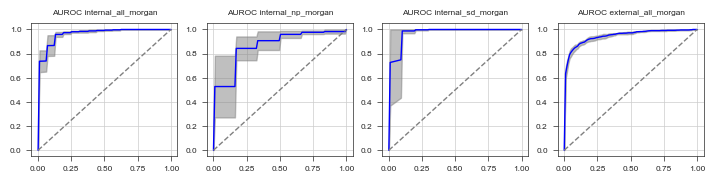

In [7]:
names = ["internal_all_morgan", "internal_np_morgan", "internal_sd_morgan", "external_all_morgan"]
fig, axs = st.create_figure(
    1, len(names), width=TWO_COLUMNS_WIDTH, height=0.25 * TWO_COLUMNS_WIDTH
)

for n in names:
    ax = axs.next()
    plot_roc_curve(ax, n)

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "roc_curves_morgan.png"), dpi=300)

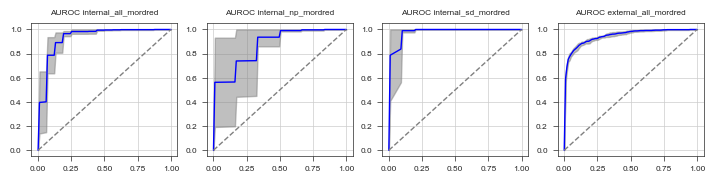

In [8]:
names = ["internal_all_mordred", "internal_np_mordred", "internal_sd_mordred", "external_all_mordred"]
fig, axs = st.create_figure(
    1, len(names), width=TWO_COLUMNS_WIDTH, height=0.25 * TWO_COLUMNS_WIDTH
)

for n in names:
    ax = axs.next()
    plot_roc_curve(ax, n)

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "roc_curves_mordred.png"), dpi=300)